In [ ]:
from thermo_validity import *
from ZW_model import LSTM
from ZW_utils import *
from ZW_generation import *
import torch.optim as optim
import matplotlib.pyplot as plt
from ZW_Opt import *
from split_functions import (
    one_hot_encoding,
    bound_creation,
    string_to_equipment,
    enforced_uniqueness,
)

dataset_id = "v28D0_m1.npy"
classes = std_classes
data_split_ratio = 0.85
batch_size = 100
max_epochs = 30
learning_rate = 0.001
model = LSTM()
loss_function = std_loss
augmentation = False
uniqueness = True
N = 10_000
cutoff = 143.957

# save_path = make_dir(
#     model,
#     batch_size,
#     learning_rate,
# )
dataset = dataloading(dataset_id)

save_path = "LSTM_NA"
# dataset = np.load(f"{save_path}/generated+7_data.npy", allow_pickle=True).tolist()
if uniqueness:
    equipments = string_to_equipment(dataset)
    dataset, _ = enforced_uniqueness(equipments)


def optimization(data_array, classes, save_path, save_name):
    one_hot_tensors = np.array(one_hot_encoding(data_array, classes), dtype=object)
    print(one_hot_tensors.shape)
    valid_layouts = set()
    penalty_layouts = set()
    broken_layouts = set()
    results = np.zeros(one_hot_tensors.shape[0])
    positions = np.zeros(one_hot_tensors.shape[0], dtype=object)
    for i in range(one_hot_tensors.shape[0]):
        layout = one_hot_tensors[i]
        equipment, bounds, x, splitter = bound_creation(layout)
        # PSO Parameters
        swarmsize_factor = 7
        particle_size = swarmsize_factor * len(bounds)
        if 5 in equipment:
            particle_size += -1 * swarmsize_factor
        if 9 in equipment:
            particle_size += -2 * swarmsize_factor
        iterations = 30
        nv = len(bounds)
        try:
            a = PSO(
                objective_function, bounds, particle_size, iterations, nv, equipment
            )
            if a.result < 1e6:
                valid_layouts.add(i)
                results[i] = a.result
                positions[i] = a.points
            else:
                penalty_layouts.add(i)
        except:
            broken_layouts.add(i)
        if i % 100 == 0:
            print(
                "Valid/Penalty/Broken",
                len(valid_layouts),
                len(penalty_layouts),
                len(broken_layouts),
            )
    results_name = "results_" + save_name + ".npy"
    positions_name = "positions_" + save_name + ".npy"
    np.save(f"{save_path}\{results_name}", results)
    np.save(f"{save_path}\{positions_name}", positions)
    return results


def optimization_filter(results, datalist, cutoff, save_name):
    nonzero_results = results[np.where(results > 0)]
    good_layouts = []
    good_results = []
    print("Optimization Results:", len(nonzero_results), len(results))
    for i in range(len(results)):
        if results[i] < cutoff and results[i] > 0:
            good_layouts.append(datalist[i])
            good_results.append(results[i])
    print("Good layouts", len(good_layouts))
    good_layouts = np.array(good_layouts, dtype=object)
    np.save(
        f"{save_path}/{save_name}_good_layouts.npy",
        good_layouts,
    )
    return good_layouts, good_results

In [ ]:
for i in range(1):
    train_loader, val_loader = data_loaders(
        dataset, batch_size, data_split_ratio, classes, augmentation
    )
    model = LSTM()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    best_model, last_model, t_loss, v_loss = packed_training(
        model, optimizer, loss_function, train_loader, val_loader, max_epochs
    )
    plot_name = str(i) + "_loss.png"
    model_name = str(i) + "_model.pt"
    data_name = str(i) + "_data.npy"
    plt.plot(t_loss, label="Training Loss")
    plt.plot(v_loss, label="Validation Loss")
    plt.legend()
    plt.savefig(f"{save_path}/{plot_name}")
    plt.clf()
    torch.save(best_model, f"{save_path}/{model_name}")
    model.load_state_dict(best_model)
    layout_list = generation(N, model=model)

In [5]:
if uniqueness:
        equipments = string_to_equipment(layout_list)

In [16]:
from split_functions import equipments_to_strings
for i, equipment in enumerate(equipments):
    try:
        if equipment[0] == 0:
            equipment = equipment[1:-1]
        indexes_of_T = np.where(np.array(equipment) == 1)[0]
        possible_rotations = np.array(
            [np.roll(equipment, -i) for i in indexes_of_T]
        )
        second_equipment = possible_rotations[:, 1]
        rotation = np.argmin(second_equipment)
        equipments[i] = possible_rotations[rotation].tolist()
    except:
        continue
designs = equipments_to_strings(equipments)
for i, design in enumerate(designs):
    designs[i] = "G" + design + "E"
for equipment in equipments:
    equipment.insert(0, 0)
    equipment.append(11)

In [44]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from ZW_utils import *
from ZW_generation import sampling
from LSTM_batch_pack import LSTMtry
classes = std_classes
model = LSTMtry(len(classes),32,12)
model.load_state_dict(torch.load(config.MODEL_DIRECTORY/"v21D5_m1.pt"))
prediction = torch.tensor(
            [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
        ).reshape(1, -1, 12)

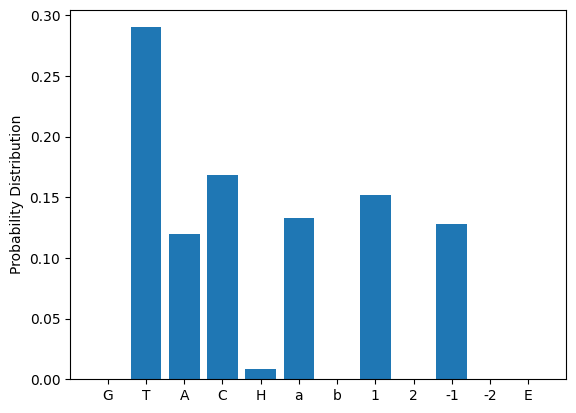

In [45]:
model.eval()
with torch.no_grad():
    softmax_output = F.softmax(model(prediction), dim=1)
    # softmax_output[0][2] = 0.0
    # softmax_output[0][4] = 0.0
    plt.bar(classes, softmax_output[0].numpy())
    plt.ylabel("Probability Distribution")
    # plt.savefig("top75.png")
    plt.show()
    # new_tensor[sampling(softmax_output)] = 1.0
    # prediction = torch.cat(
    #     (prediction[0], new_tensor.reshape(1, 12))
    # ).reshape(1, -1, 12)
    # print(prediction)